In [1]:
import os
import time
import sys
import json
import numpy as np
import torch as th
import matplotlib.pyplot as plt
import motornet as mn
from simple_policy import Policy
from simple_task import CentreOutFFMinJerk
from simple_utils import *
from tqdm import tqdm

print('All packages imported.')
print('pytorch version: ' + th.__version__)
print('numpy version: ' + np.__version__)
print('motornet version: ' + mn.__version__)

All packages imported.
pytorch version: 2.2.0.dev20231105
numpy version: 1.24.1
motornet version: 0.2.0


In [2]:
device = th.device("cpu")

effector = mn.effector.RigidTendonArm26(muscle=mn.muscle.RigidTendonHillMuscle())
env = CentreOutFFMinJerk(effector=effector, max_ep_duration=1.)

policy = Policy(env.observation_space.shape[0], 128, env.n_muscles, device=device)
optimizer = th.optim.Adam(policy.parameters(), lr=10**-3)

In [3]:
batch_size = 64
n_batch    = 10000

losses = []

for batch in tqdm(range(n_batch),
                  desc=f"Training {n_batch} batches of {batch_size}",
                  unit="batch"):

    data = run_episode(env, policy, batch_size, catch_trial_perc=50, condition='train', ff_coefficient=0.0, detach=False)
    loss, _, muscle_loss, hidden_loss, _, _ = cal_loss(data, env.muscle.max_iso_force, env.dt, policy, test=False)

    # backward pass & update weights
    optimizer.zero_grad() 
    loss.backward()
    th.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=1.)  # important!
    optimizer.step()


Training 10000 batches of 64: 100%|██| 10000/10000 [1:00:39<00:00,  2.75batch/s]


In [4]:
weight_file = 'simple_weights'
log_file    = 'simple_log.json'
cfg_file    = 'simple_cfg.json'

# save model weights
th.save(policy.state_dict(), weight_file)

# save training history (log)
with open(log_file, 'w') as file:
    json.dump({'losses':losses}, file)

# save environment configuration dictionary
cfg = env.get_save_config()
with open(cfg_file, 'w') as file:
    json.dump(cfg, file)


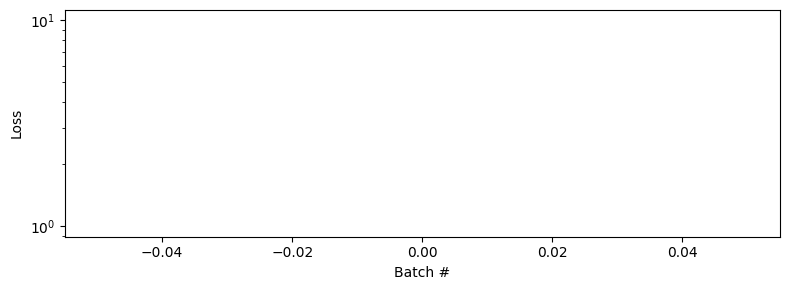

In [5]:
plot_training_log(losses)

In [6]:
cfg_file = "simple_cfg.json"
weight_file = "simple_weights"

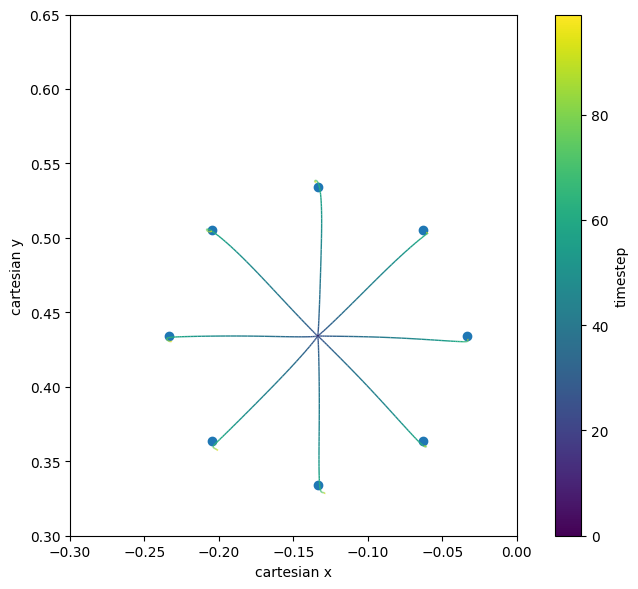

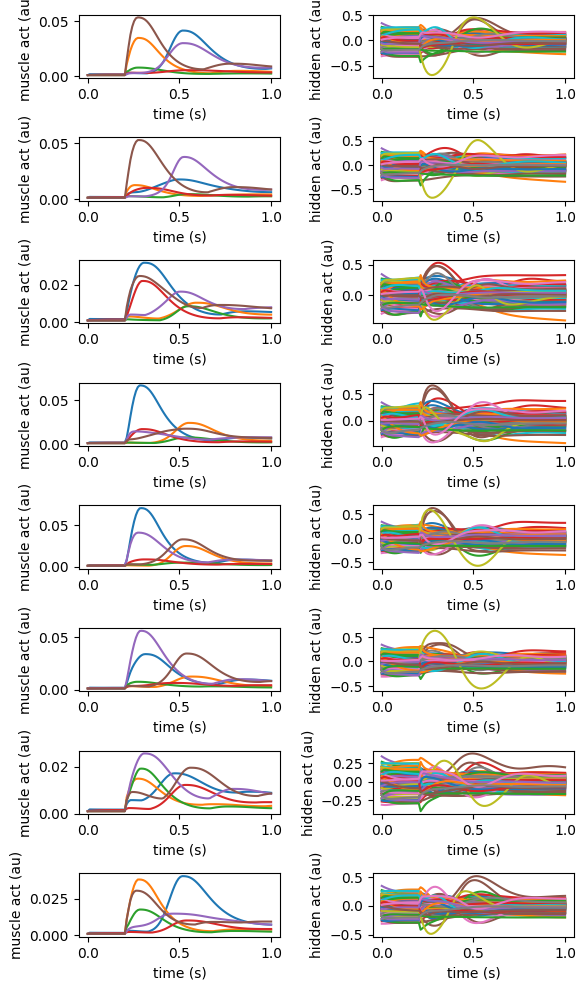

In [7]:
# TEST NETWORK ON CENTRE-OUT

data = test(cfg_file, weight_file)

fig, ax  = plot_simulations(xy=data['xy'],target_xy=data['tg'], figsize=(8,6))

fig, ax = plot_activation(data['all_hidden'], data['all_muscle'])
